In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from pennylane import qaoa

In [2]:
def codificar_amistades(amistades):
    # Transforma el array de nombres de personas a array de índices
    return np.unique(amistades, return_inverse=True)

In [3]:
def construir_circuito(personas_idxs, amistades_idxs):
    dev = qml.device("default.qubit", wires=personas_idxs)

    # Construir capas C y B.
    grafo_amistades = nx.Graph()
    grafo_amistades.add_edges_from(amistades_idxs)

    C_h, B_h = qaoa.min_vertex_cover(grafo_amistades, constrained=False)
    def capa_qaoa(gamma, beta):
        qaoa.cost_layer(gamma, C_h)
        qaoa.mixer_layer(beta, B_h)

    @qml.qnode(dev)
    def circuit(params):
        for persona_idx in personas_idxs:
            qml.Hadamard(wires=persona_idx)
        qml.layer(capa_qaoa, 3, params[0], params[1])

        return qml.probs(wires = personas_idxs)

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(C_h)

    return circuit, cost_function

In [43]:
def optimizar_parametros(circuito, cantidad_personas):
    params = [[1.0/cantidad_personas]*3,[1.0/cantidad_personas]*3]
    optimizer = qml.GradientDescentOptimizer()
    steps = 50
    params = np.array(params, requires_grad=True)
    for i in range(steps):
        params = optimizer.step(circuito, params)
    return params

In [44]:
def a_binario(resultado, digitos):
    binario = bin(resultado)[2:]
    return binario.zfill(digitos)

In [45]:
def a_quien_contratar(amistades):
    # Codificar amistades
    personas, amistades_idxs = codificar_amistades(amistades)
    personas_idxs = range(personas.size)

    # Generar circuito y parámetros
    circuito, funcion_costo = construir_circuito(personas_idxs, amistades_idxs)
    parametros = optimizar_parametros(funcion_costo, personas.size)

    # Obtener resultado
    probs = circuito(parametros)
    resultado = np.argmax(probs)
    plt.bar(range(2 ** len(personas_idxs)), probs)

    # Decodificar resultado y devolver personas elegidas
    personas_elegidas = []
    for idx, valor_binario in enumerate(a_binario(resultado, len(personas_idxs))):
        if valor_binario == "0":
            personas_elegidas.append(str(personas[idx]))
    return personas_elegidas

## Prueba

['Ana', 'Raul', 'Sarah']

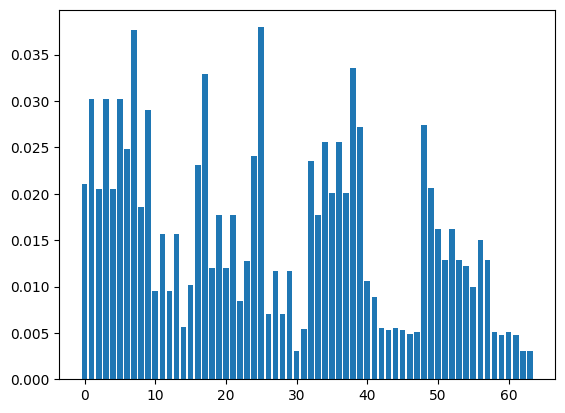

In [46]:
amistades = [["Mario", "Sarah"],
            ["Mario", "Raul"],
            ["Mario", "Ana"],
            ["Enrique", "Sarah"],
            ["Enrique", "Raul"],
            ["Saul", "Ana"]]

a_quien_contratar(amistades)

['Mario']

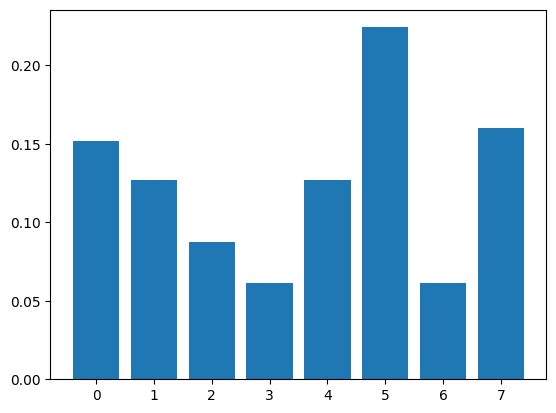

In [48]:
amistades = [["Mario", "Sarah"],
            ["Mario", "Ana"]]

a_quien_contratar(amistades)